# Retina Pathology Diagnosis
#### Introduction to Deep Learning, University of Colorado, Boulder

#### Problem Statement
This project attempts to classify optical coherence tomography (OCT) images of the retina.  OCT is a non-invasive imaging technique that uses light to generate cross-sectional scans.  When applied to the retina, a number of pathologies can be identified.  Traditionally, diagnoses have been made manually by a qualified medical professional.  However, with the power of neural networks, it should be possible to automatically detect the health of the retina.  If such automatic diagnosis accuracy is comparable with a human, then automating this task could help reduce the costs associated with identifying retinal issues.   

In addition to attempting to achieve a high classification accuracy on this task, I would also like to explore the use of transfer learning to speed up training on neural network image classification.  The Keras module offers a number of out-of-the-box neural network architectures with training weights that have already been optimized on the ImageNet dataset.  While the ImageNet dataset is composed of everday objects (not scans of retinas), it may be possible to leverage the existing learning for improved performance and faster training.  As the training time for state-of-the-art neural networks can be weeks, using pre-trained models could make the most powerful classfication accessible.  It would just be necessary to train the lower levels of the model, and then do a short fine-tuning of the model with a very low learning rate.  

This final project is also published on GitHub here: 
> https://github.com/slilly4/OCT-Retina-Classification

#### Data

The data for this project has been obtained from the following dataset:
> <b>Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images”, Mendeley Data, V3, doi: 10.17632/rscbjbr9sj.3</b>

The images were initially used for research conducted by Daniel S. Kermany and other researchers at the University of California San Diego and the Guangzhou Women and Children's Medical Center.  Their results were published in the 2018 article, "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning."


In [2]:
import os
import numpy as np 
import pandas as pd 
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, add
from keras import regularizers, optimizers
import time
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn import metrics
from keras.layers import concatenate
from keras.layers import Input
from keras.models import Model

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Exporatory Data Analysis

After downloading the data from https://data.mendeley.com/datasets/rscbjbr9sj/3, I began to acquaint myself with the available files in order to devise the best strategy for loading the images into a dataset usable for neural network training.  

The available images are segmented into folders based on their classification.  There are four classifications

> Choroidal Neovascularization (CNV)

> Diabetic Macular Edema (DME)

> Drusen

> Normal

Below is a random image from the CNV class:

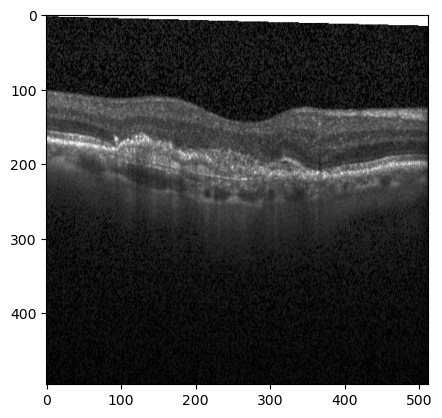

In [12]:
img = cv2.imread("/kaggle/input/oct-xrays/ZhangLabData/CellData/OCT/train/CNV/CNV-1016042-1.jpeg")
plt.imshow(img)

In [13]:
img.shape

(496, 512, 3)

It appears that the image has an irregular shape, and it has been slightly skewed.  It is possible the original researchers added the tilt for their own training purposes.  This fact brings to mind that image classification tasks often perform well when data is given in a variety of orientations.  It can help the network to learn how to identify objects from a number of real life perspectives.  

I also notice that there are three color channels, even though the images appears to be in grayscale.  We will need to identify whether this three-channel dimension is consistent.  We might be able to reduce these images to grayscale, if that could help with training.  

I will now visualize a selection from each class to better discern the sizes and orientations of the images.  The following function will be used to preview 15 images at a time.

In [ ]:
def preview_15(img_dir, title):
    num_rows = 3
    num_cols = 5
    image_index = 0
    img_list = os.listdir(img_dir)
    image_location = img_list[:15]

    fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15,9))
    fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):  
            im = cv2.imread(img_dir + image_location[image_index])
            axes[i, j].imshow(im)
            axes[i, j].set_title(im.shape, size=10)
            image_index += 1

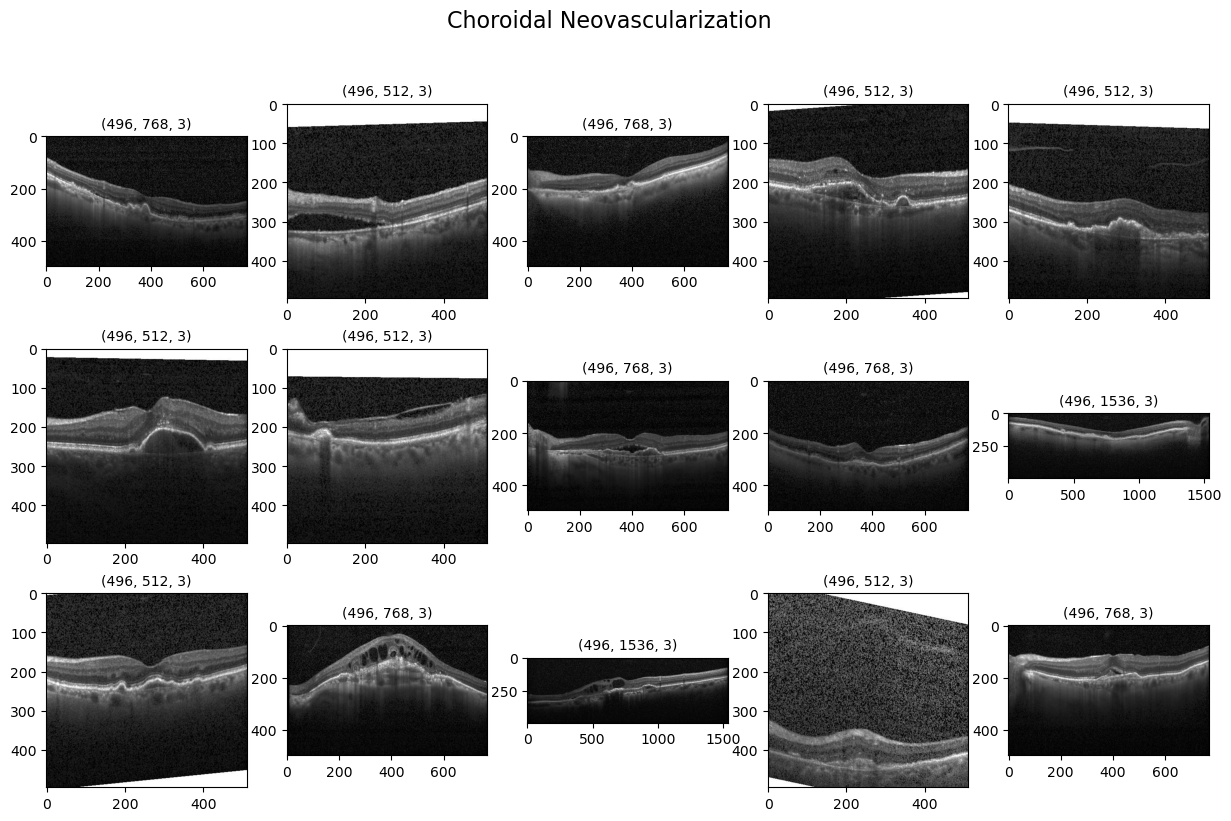

In [29]:
preview_15("/kaggle/input/oct-xrays/ZhangLabData/CellData/OCT/train/CNV/", "Choroidal Neovascularization")

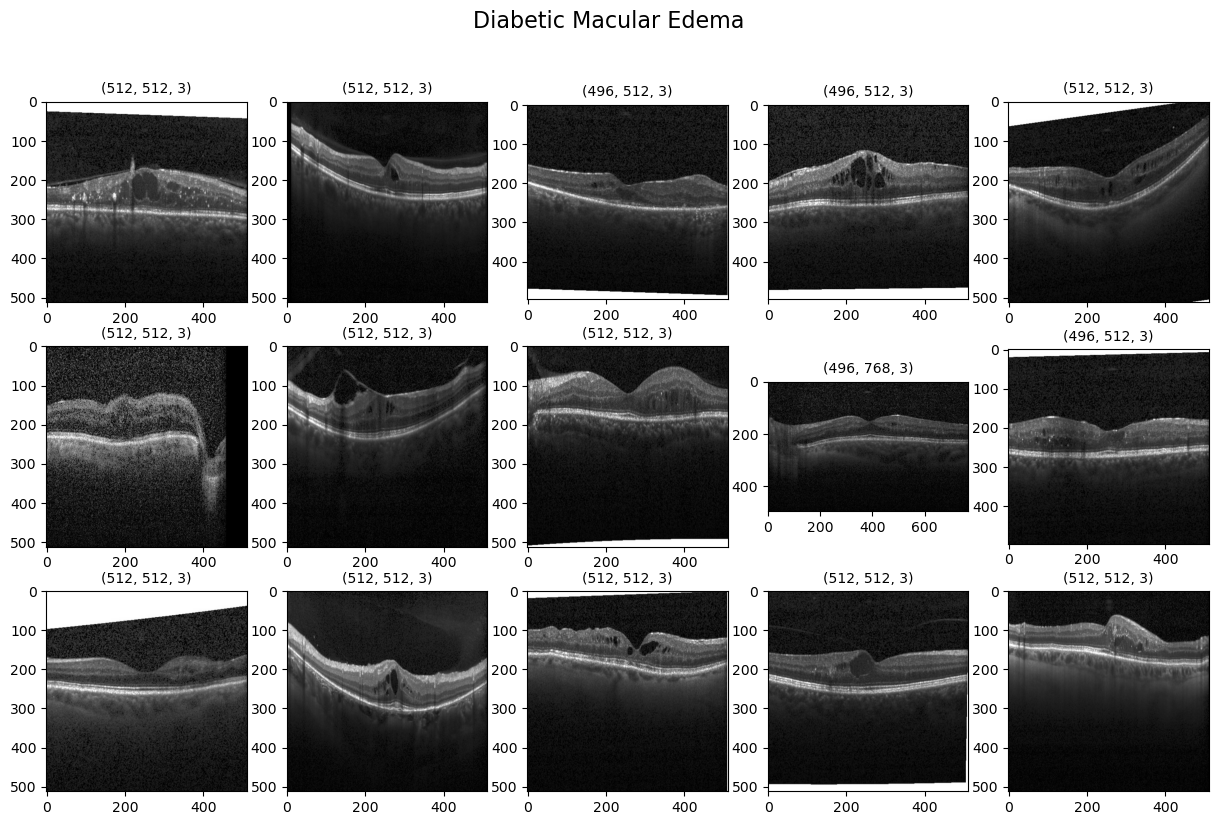

In [30]:
preview_15("/kaggle/input/oct-xrays/ZhangLabData/CellData/OCT/train/DME/", "Diabetic Macular Edema")

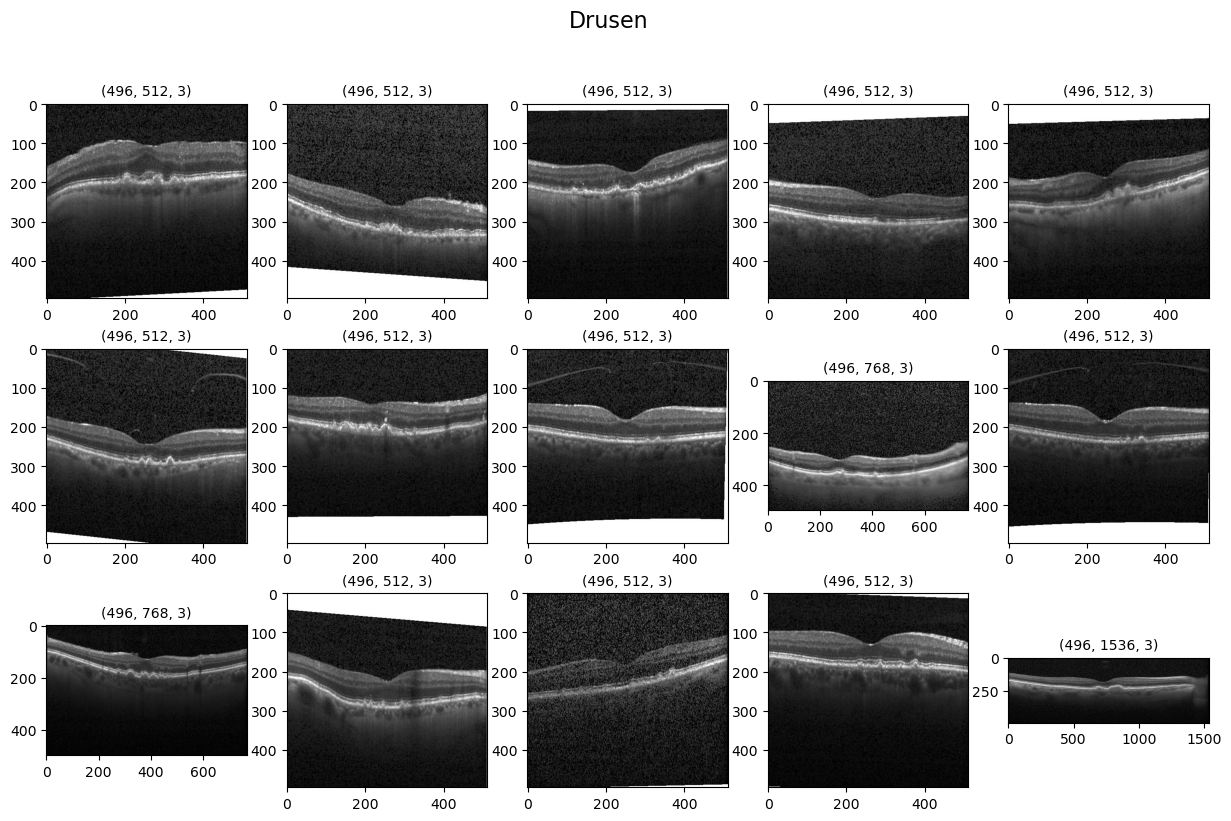

In [31]:
preview_15("/kaggle/input/oct-xrays/ZhangLabData/CellData/OCT/train/DRUSEN/", "Drusen")

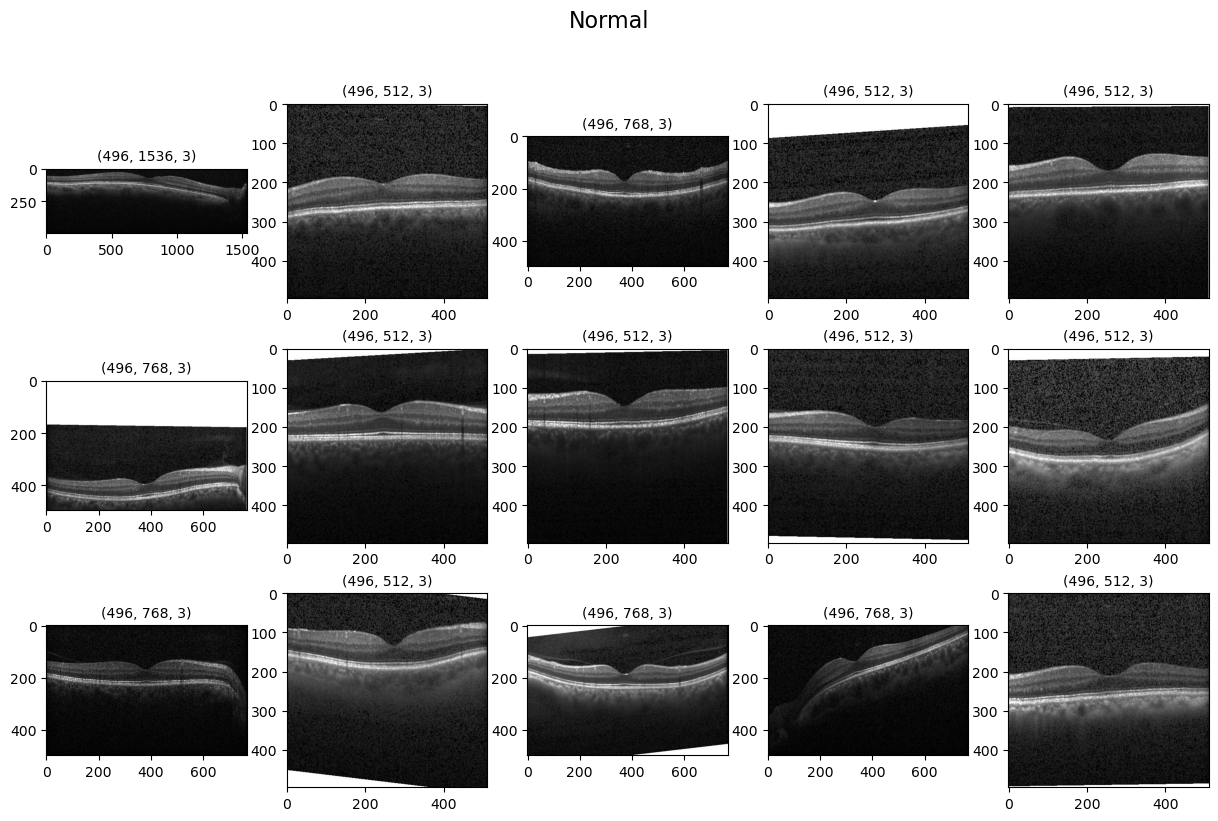

In [32]:
preview_15("/kaggle/input/oct-xrays/ZhangLabData/CellData/OCT/train/NORMAL/", "Normal")

There are a wide variety of image sizes.  It will be necessary to standardize these before training the neural network, as it is not possible to have inputs of different dimensions.  Also, it appears the skew of the images may have been done so that all of the retinas are pointing vertically.  However, this is not completely consistent.  

Next I would like to see how many images are available in each class.

In [56]:
def count_images(img_dir, title):
    print(title)
    for d in os.listdir(img_dir):
        full_path = img_dir + d
        print(d + ": " + str(len(os.listdir(full_path))))


In [57]:
count_images("/kaggle/input/oct-xrays/ZhangLabData/CellData/OCT/train/","Train Totals")

Train Totals
DRUSEN: 8616
CNV: 37205
NORMAL: 51140
DME: 11348


There is a big difference in the numbers of images per class.  There are many more images of Normal and CNV than there are of Drusen and DME.  If there is poor initial training performance, then it may be necessary to oversample the classes that have fewer images. 

In [60]:
def count_images_list(img_dir):
    count = []
    name = []
    for d in os.listdir(img_dir):
        full_path = img_dir + d
        count.append(len(os.listdir(full_path)))
        name.append(d)
    return count, name

Text(0.5, 1.0, 'Training Data')

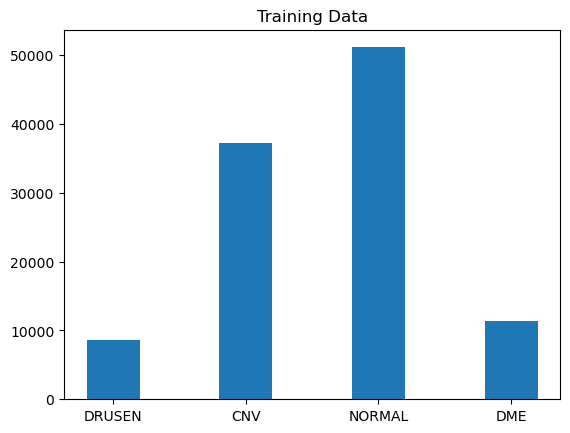

In [67]:
train_count, train_name = count_images_list("/kaggle/input/oct-xrays/ZhangLabData/CellData/OCT/train/")
plt.bar(train_name, train_count, width = 0.4)
plt.title("Training Data")

# Data Preparation

Based on what has been seen thus far, I will prepare the images into a dataset for convolutional neural network training.  There are over 108,000 images, so I will split them 80/20 into train and validation batches.  I will also retain a 1,000 image testing batch, which is composed of 250 images of each class.  This will be utilized in the Analyze section of this project.  

As mentioned previously, it could be helpful to add additional variations in the images to help with training.  Therefore, I will add in flipping, zooming, and shear to further diversify the training set.  This hopefully will improve classfication regardless of the way the retina was captured in the scan.

As neural networks work best on normalized data, the pixel values will be scaled to values between 0 and 1.  

To standardize the image dimensions, I chose 496x496 pixels.  496 pixels appears to be the minimum dimension value in the data.  This is quite large, but I hope that the extra data will help improve performance.  It may also make the training very long.  

For the color mode, I was hoping that I might be able to transform the images into grayscale as that would reduce some data that is unnecessary; however, after some additional investigation I determined that it would be necessary to keep the three channels.  The pre-trained model will require three channels.  

I chose a batch size of 32. I wonder if this is too small.  However, resources online suggest that batch sizes of 32 to 64 work best. But, given that this is such a big dataset, I wonder if a bigger batch size could have helped with training times.   

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [64]:
train_generator = train_datagen.flow_from_directory(
    directory="/kaggle/input/oct-xrays/ZhangLabData/CellData/OCT/train/",
    target_size=(496, 496),
    subset = "training",
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=0
)

valid_generator = train_datagen.flow_from_directory(
    directory="/kaggle/input/oct-xrays/ZhangLabData/CellData/OCT/train/",
    target_size=(496, 496),
    subset = "validation",
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=0
)

Found 86648 images belonging to 4 classes.
Found 21661 images belonging to 4 classes.


In [96]:
print(train_generator.class_indices)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


The classes are encoded into numbers/targets as seen above.

Next I will turn my attention to building models from scratch, so that we have a control to compare to the pre-trained model.

# VGG Model

For a first attempt at training a model, I will use a VGG-style architecture.  Since I have limited computing capacity, the model will not include as many layers and filters as would be desirable; however, it is hoped that that five repeating layers of convolution and pooling can allow for decent performance.  My model will be composed of two convolution layers with 16 filters with a Max Pool layer, followed by two convolution layers with 32 filters with a Max Pool layer, followed by two convolution layers with 64 layers with a max pool layer, followed by two convolution layers with 128 filters followed by a max pool layer, followed by two convolution layers with 256 filters followed by a max pool layer.  Then I will add two fully-connected dense layers to aid with classification.  At the end a softmax activation function will be used so that we have the possiblity of multi-class classification.  Accuracy, Precision, Recall, AUC will be used as metrics.  Adam will be used as an optimzer, as it is known to very computational efficient.

The following image was used as a guide for this model.  The filters were reduced as well as the total number of layers.  As it is composed, the model includes over 1.5 million parameters.

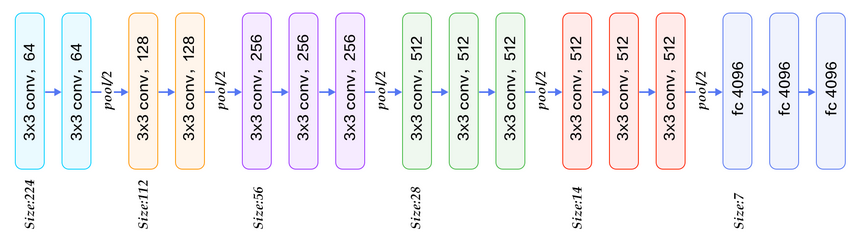

https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide

In [13]:
vgg_model = Sequential()
vgg_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation="relu", input_shape=(496, 496, 3)))
vgg_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Dense(512, activation="relu"))
vgg_model.add(Dense(512, activation="relu"))
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(4, activation="softmax"))
vgg_model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=[tf.keras.metrics.TruePositives(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(), tf.keras.metrics.CategoricalAccuracy()])

In [14]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 496, 496, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 496, 496, 16)      2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 165, 165, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 165, 165, 32)      4640      
                                                                 
 conv2d_11 (Conv2D)          (None, 165, 165, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                  

In [15]:
checkpoint_filepath_vgg = './checkpoints_vgg'
model_checkpoint_vgg = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_vgg,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Since the training for this task is so heavy, I began with the intention of training for three epochs.  Checkpoints will be used to save the models.  

In [ ]:
st = time.process_time()
vgg_stats = vgg_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3, callbacks=[model_checkpoint_vgg])
et = time.process_time()
res = et - st
print('Execution time:', et - st, 'seconds')

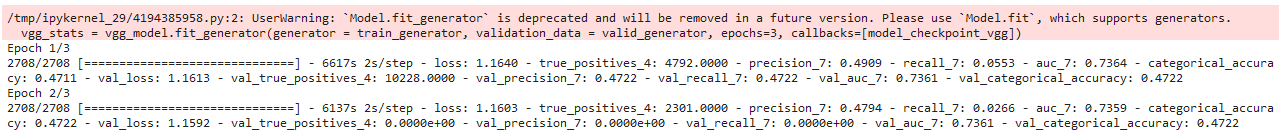

After training for nearly two epochs, it became clear that the model stopped training.  Those partial results are shown above in a screenshot.  It is not entirely clear why this occured, but there was no point continuing.  It would be necessary to modify the model.  I have found in the past the simpler models can have better learning than more complex ones.  Therefore, I reduced the number of layers and the size of the fully connected layers.  This shrinks the model to about 327,000 parameters.  Perhaps this will be more manageable.

In [5]:
vgg_model = Sequential()
vgg_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation="relu", input_shape=(496, 496, 3)))
vgg_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Dense(128, activation="relu"))
vgg_model.add(Dense(128, activation="relu"))
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(4, activation="softmax"))
vgg_model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=[tf.keras.metrics.TruePositives(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(), tf.keras.metrics.CategoricalAccuracy()])

In [6]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 496, 496, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 496, 496, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 165, 165, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 165, 165, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 165, 165, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                    

In [6]:
st = time.process_time()
vgg_stats = vgg_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3)
et = time.process_time()
res = et - st
print('Execution time:', et - st, 'seconds')

/tmp/ipykernel_28/4203019136.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg_stats = vgg_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3)


Epoch 1/3
2708/2708 [==============================] - 6242s 2s/step - loss: 0.5281 - true_positives: 65617.0000 - precision: 0.8636 - recall: 0.7573 - auc: 0.9524 - categorical_accuracy: 0.8119 - val_loss: 0.3331 - val_true_positives: 19122.0000 - val_precision: 0.9086 - val_recall: 0.8828 - val_auc: 0.9795 - val_categorical_accuracy: 0.8946
Epoch 2/3
2708/2708 [==============================] - 5956s 2s/step - loss: 0.3176 - true_positives: 76234.0000 - precision: 0.9089 - recall: 0.8798 - auc: 0.9805 - categorical_accuracy: 0.8951 - val_loss: 0.3610 - val_true_positives: 18315.0000 - val_precision: 0.9104 - val_recall: 0.8455 - val_auc: 0.9766 - val_categorical_accuracy: 0.8868
Epoch 3/3
2708/2708 [==============================] - 5934s 2s/step - loss: 0.2805 - true_positives: 77905.0000 - precision: 0.9220 - recall: 0.8991 - auc: 0.9840 - categorical_accuracy: 0.9110 - val_loss: 0.3145 - val_true_positives: 19406.0000 - val_precision: 0.9148 - val_recall: 0.8959 - val_auc: 0.9807 

The results are very encouraging; though the training time is much longer than I hoped for.  It took nearly 5 hours to train these 3 epochs, and this is in addition to testing and the previous failed run.  Validation accuracy is over .90, and the validation AUC is above .98.  After only 3 epochs, these are strong results.  

|Metric|Training|Validation|
|:----|:--------:|:--------:|
|Loss | 0.2805 | 0.3145 |
|Precision | 0.9220 | 0.9148 | 
|Recall | 0.8991 | 0.8959 |
|AUC | 0.9840 | 0.9807 | 
|Accuracy | 0.9110 | 0.9053 | 

In [7]:
vgg_model.save('/kaggle/working/vgg_model2.keras')

In [8]:
def show_stats(stats, epochs):
    stats_list = []
    for key, values in stats.history.items():
        stats_list.append((key,values))

    num_rows = 2
    num_cols = 6
    stat_index = 0

    fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15,6))

    for i in range(num_rows):
        for j in range(num_cols):  
            axes[i, j].plot(range(1,epochs+1),stats_list[stat_index][1])
            axes[i,j].set_title(stats_list[stat_index][0], fontsize=7)
            axes[i,j].xaxis.set_tick_params(labelsize=5)
            axes[i,j].yaxis.set_tick_params(labelsize=5)
            stat_index += 1

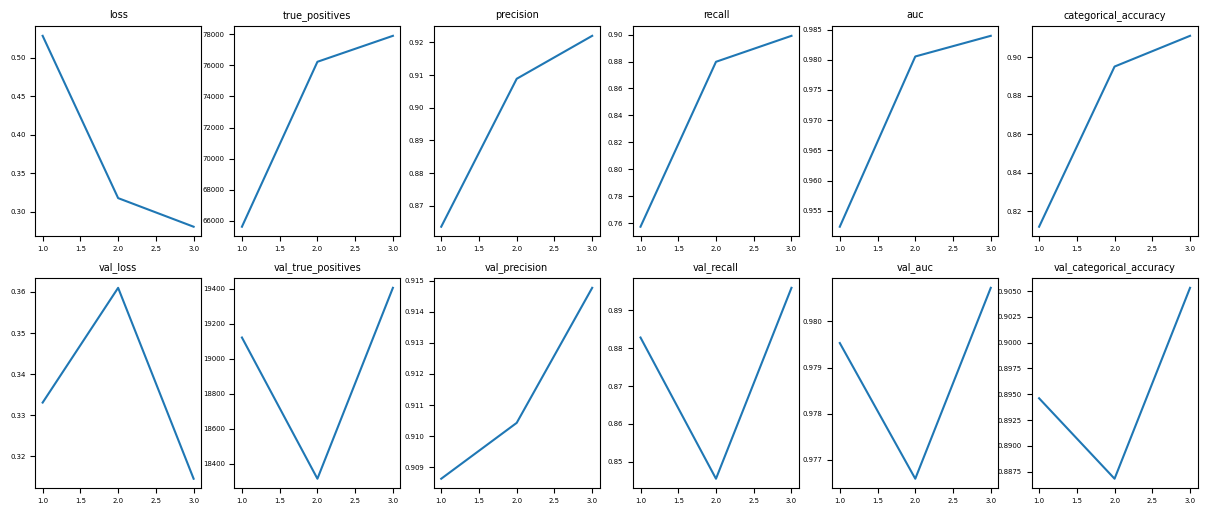

In [9]:
show_stats(vgg_stats, 3)

The graphs suggest that more learning can be accomplished with additional epochs of training.  Therefore, we will add another 3 epochs, for a total of 6.  This will bring the training time of the model to 10 hours.  This should provide a good baseline for the pre-trained model.

In [6]:
st = time.process_time()
vgg_stats2 = vgg_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3)
et = time.process_time()
res = et - st
print('Execution time:', et - st, 'seconds')

/tmp/ipykernel_28/2021134267.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg_stats2 = vgg_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3)


Epoch 1/3
2708/2708 [==============================] - 6499s 2s/step - loss: 0.2658 - true_positives: 78549.0000 - precision: 0.9263 - recall: 0.9065 - auc: 0.9851 - categorical_accuracy: 0.9167 - val_loss: 0.2824 - val_true_positives: 19703.0000 - val_precision: 0.9244 - val_recall: 0.9096 - val_auc: 0.9844 - val_categorical_accuracy: 0.9161
Epoch 2/3
2708/2708 [==============================] - 5902s 2s/step - loss: 0.2657 - true_positives: 78582.0000 - precision: 0.9284 - recall: 0.9069 - auc: 0.9853 - categorical_accuracy: 0.9182 - val_loss: 0.2462 - val_true_positives: 19856.0000 - val_precision: 0.9343 - val_recall: 0.9167 - val_auc: 0.9874 - val_categorical_accuracy: 0.9264
Epoch 3/3
2708/2708 [==============================] - 5929s 2s/step - loss: 0.2691 - true_positives: 78582.0000 - precision: 0.9280 - recall: 0.9069 - auc: 0.9848 - categorical_accuracy: 0.9175 - val_loss: 0.2237 - val_true_positives: 20063.0000 - val_precision: 0.9417 - val_recall: 0.9262 - val_auc: 0.9886 

In [8]:
vgg_model.save('/kaggle/working/vgg_model4.keras')

Interestingly the model performed better on the validation data than the training data.  I'm not sure why this would be.  However, it is encouraging to see that the model transfers well to data what was not used for training. 

|Metric|Training|Validation|
|:----|:--------:|:--------:|
|Loss | 0.2691 | 0.2237 |
|Precision | 0.9280 | 0.9417 | 
|Recall | 0.9069 | 0.9262 |
|AUC | 0.9848 | 0.9886 | 
|Accuracy | 0.9175 | 0.9343 | 

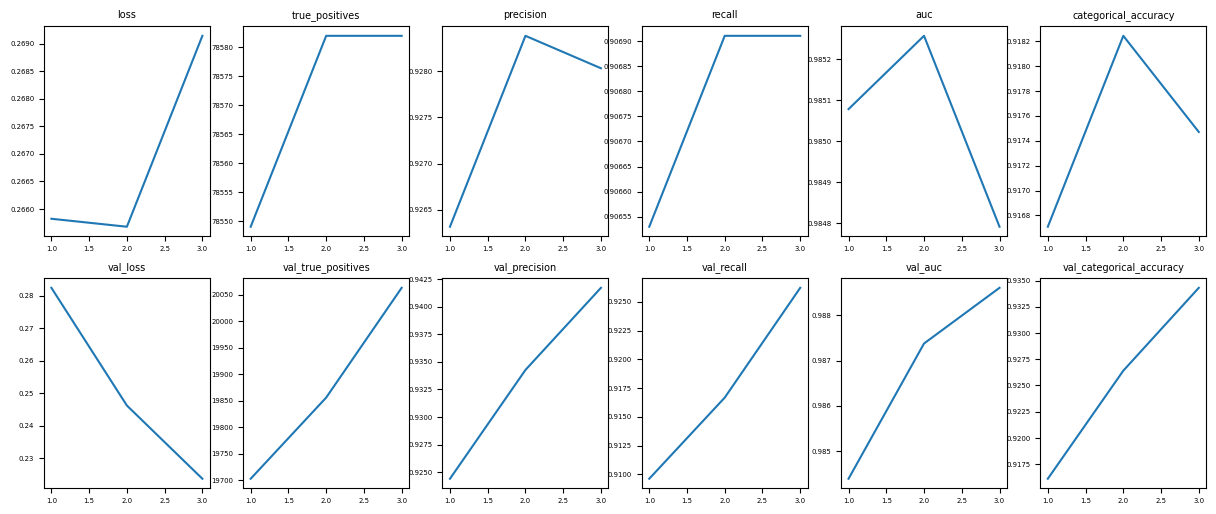

In [12]:
show_stats(vgg_stats2, 3)

I am happy to see an validation accuracy of .93, and both validation precision and recall are above .92 as well.  Validation AUC is above .98.  This is great to see.  It is possible that additional gains could be obtained, but I believe that this will give us a good baseline for the pre-trained model.  Also, I have limited availability for GPUs and TPUs.

# ResNet Model

Next, I will attempt this image classification problem by using a ResNet-style architecture.  Such an architecture is noted for improving efficiency and reducing the risk of exploding/vanishing gradient.  The ResNet includes "skips" between the layers, allowing for deeper neural networks.  The following images provides a diagram of one implementation of ResNet.

I settled for an architecture with 4 blocks.  Each of these blocks includes one path with two convolution layers which is then merged with the input layer.  At the beginning I used normalization and max pooling layers.  The maxpooling should reduce the dimensions by 2, making the data size more manageable. At the end average pooling is used. I kept my filter sizes much smaller due to memory issues.  The first block includes filters of 16, while subsequent blocks have sizes of 32 and 64.  

Inspiration for my implementation of the model comes from: https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/ , the image below from https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758 and our class lectures.  

Overall, there are more than 15.8 million parameters in this model.  

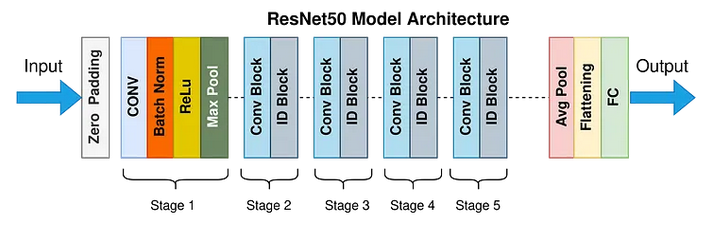

https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758

In [12]:
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


#Input Layer
layer_in = Input(shape=(496, 496, 3))
norm1 = BatchNormalization(gamma_initializer=gamma_init)(layer_in)
relu = layers.ReLU()(norm1)
maxpool = MaxPooling2D(pool_size=(2, 2), padding="same")(relu)

# Layer 1

# One layer that skips the Convolutions.  A 1x1 Convolution is used to match the sizes.
merge_input = Conv2D(16, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(maxpool)

# Two Convolution layers
conv1 = Conv2D(16, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(maxpool)
conv2 = Conv2D(16, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)

# Add the Convolution output and the original input and add the Activation function
layer_out = add([conv2, merge_input])
layer_out = Activation('relu')(layer_out)


# Layer 2

# One layer that skips the Convolutions.  A 1x1 Convolution is used to match the sizes.
merge_input_1 = Conv2D(32, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out)

# Two Convolution layers
conv1_1 = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out)
conv2_1 = Conv2D(32, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1_1)

# Add the Convolution output and the original input and add the Activation function
layer_out_1 = add([conv2_1, merge_input_1])
layer_out_1 = Activation('relu')(layer_out_1)


# Layer 3

# One layer that skips the Convolutions.  A 1x1 Convolution is used to match the sizes.
merge_input_2 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out_1)

# Two Convolution layers
conv1_2 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out_1)
conv2_2 = Conv2D(64, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1_2)

# Add the Convolution output and the original input and add the Activation function
layer_out_2 = add([conv2_2, merge_input_2])
layer_out_2 = Activation('relu')(layer_out_2)


# Layer 4

# One layer that skips the Convolutions.  A 1x1 Convolution is used to match the sizes.
merge_input_3 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out_2)

# Two Convolution layers
conv1_3 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out_2)
conv2_3 = Conv2D(64, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1_3)

# Add the Convolution output and the original input and add the Activation function
layer_out_3 = add([conv2_3, merge_input_3])
layer_out_3 = Activation('relu')(layer_out_3)

pool = AveragePooling2D((3,3), strides=(1,1), padding='same')(layer_out_3)
flatten = Flatten()(pool)
layer_out_6 = Dense(4, activation="softmax")(flatten)

resnet_model = Model(inputs=layer_in, outputs=layer_out_6)
resnet_model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=[tf.keras.metrics.TruePositives(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 496, 496, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 496, 496, 3)  12         ['input_3[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 re_lu_1 (ReLU)                 (None, 496, 496, 3)  0           ['batch_normalization_1[0][0]']  
                                                                                            

In [13]:
checkpoint_filepath_res = './checkpoints_res'
model_checkpoint_res = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_res,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
st = time.process_time()
resnet_stats = resnet_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3, callbacks=[model_checkpoint_res])
et = time.process_time()
print('Execution time:', et - st, 'seconds')

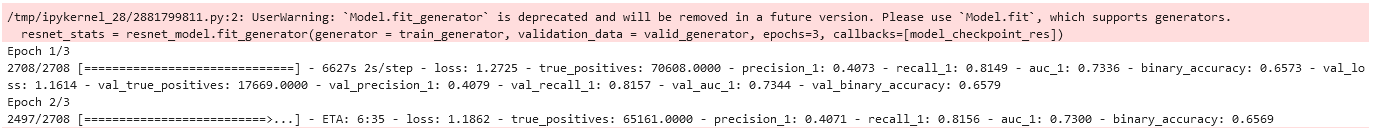

Unfortunately, the model stopped learning.  The screenshot above shows the result.  I will again attempt to simplify the model.  I will remove some of the additional layers at the beginning and end, and I will see if that improves performance at all.    

In [18]:
layer_in = Input(shape=(496, 496, 3))

# This is for the first column of layers:  A 1x1 Convolution
col1 = Conv2D(16, (1,1), padding='same', activation='relu')(layer_in)

# This is for the second column of layers: A 1x1 Convolution which flows into a 3x3 convolution
col2 = Conv2D(24, (1,1), padding='same', activation='relu')(layer_in)
col2 = Conv2D(32, (3,3), padding='same', activation='relu')(col2)

# This is for the third column of layers: A 1x1 Convolution which flows into a 5x5 convolution
col3 = Conv2D(8, (1,1), padding='same', activation='relu')(layer_in)
col3 = Conv2D(16, (5,5), padding='same', activation='relu')(col3)

# This is for the fourth column of layers: A 3x3 Max Pool which flows into a 1x1 convolution
col4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
col4 = Conv2D(16, (1,1), padding='same', activation='relu')(col4)

# This concatenates the four columns of layers
layer_out = concatenate([col1, col2, col3, col4], axis=-1)

#This repeats the process for a second time:

# This is for the first column of layers:  A 1x1 Convolution
col1_2 = Conv2D(32, (1,1), padding='same', activation='relu')(layer_out)

# This is for the second column of layers: A 1x1 Convolution which flows into a 3x3 convolution
col2_2 = Conv2D(32, (1,1), padding='same', activation='relu')(layer_out)
col2_2 = Conv2D(48, (3,3), padding='same', activation='relu')(col2_2)

# This is for the third column of layers: A 1x1 Convolution which flows into a 5x5 convolution
col3_2 = Conv2D(8, (1,1), padding='same', activation='relu')(layer_out)
col3_2 = Conv2D(16, (5,5), padding='same', activation='relu')(col3_2)

# This is for the fourth column of layers: A 3x3 Max Pool which flows into a 1x1 convolution
col4_2 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_out)
col4_2 = Conv2D(16, (1,1), padding='same', activation='relu')(col4_2)

# This concatenates the four columns of layers
layer_out_2 = concatenate([col1_2, col2_2, col3_2, col4_2], axis=-1)

layer_out_2 = GlobalAveragePooling2D()(layer_out_2)
layer_out_2 = Dense(4, activation="softmax")(layer_out_2)

inception_model = Model(inputs=layer_in, outputs=layer_out_2)
inception_model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=[tf.keras.metrics.TruePositives(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(), tf.keras.metrics.CategoricalAccuracy()])
    
inception_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 496, 496, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_55 (Conv2D)             (None, 496, 496, 24  96          ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_57 (Conv2D)             (None, 496, 496, 8)  32          ['input_6[0][0]']                
                                                                                            

In [ ]:
st = time.process_time()
inception_stats = inception_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3, callbacks=[model_checkpoint_vgg])
et = time.process_time()
print('Execution time:', et - st, 'seconds')

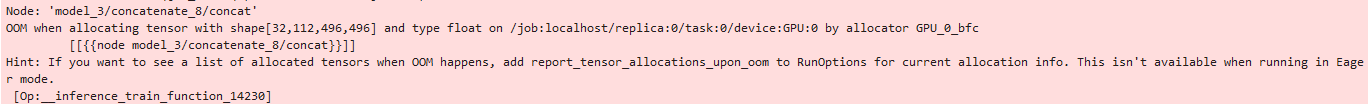

This too is unsuccessful.  There is a Out of Memory error, the dimensions are just too big.  Therefore, I will add back in the initial max pooling layer to but the size in half.  There are now about 153,000 parameters in the model.  Also, due to the need to stay under GPU and TPU quotas, I will switch to the TPU here

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    #print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [25]:
with strategy.scope():
    #Input Layer
    layer_in = Input(shape=(496, 496, 3))
    maxpool = MaxPooling2D(pool_size=(2, 2), padding="same")(layer_in)

    # Layer 1

    # One layer that skips the Convolutions.  A 1x1 Convolution is used to match the sizes.
    merge_input = Conv2D(16, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(maxpool)

    # Two Convolution layers
    conv1 = Conv2D(16, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(maxpool)
    conv2 = Conv2D(16, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)

    # Add the Convolution output and the original input and add the Activation function
    layer_out = add([conv2, merge_input])
    layer_out = Activation('relu')(layer_out)


    # Layer 2

    # One layer that skips the Convolutions.  A 1x1 Convolution is used to match the sizes.
    merge_input_1 = Conv2D(32, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out)

    # Two Convolution layers
    conv1_1 = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out)
    conv2_1 = Conv2D(32, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1_1)

    # Add the Convolution output and the original input and add the Activation function
    layer_out_1 = add([conv2_1, merge_input_1])
    layer_out_1 = Activation('relu')(layer_out_1)


    # Layer 3

    # One layer that skips the Convolutions.  A 1x1 Convolution is used to match the sizes.
    merge_input_2 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out_1)

    # Two Convolution layers
    conv1_2 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out_1)
    conv2_2 = Conv2D(64, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1_2)

    # Add the Convolution output and the original input and add the Activation function
    layer_out_2 = add([conv2_2, merge_input_2])
    layer_out_2 = Activation('relu')(layer_out_2)


    # Layer 4

    # One layer that skips the Convolutions.  A 1x1 Convolution is used to match the sizes.
    merge_input_3 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out_2)

    # Two Convolution layers
    conv1_3 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out_2)
    conv2_3 = Conv2D(64, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1_3)

    # Add the Convolution output and the original input and add the Activation function
    layer_out_3 = add([conv2_3, merge_input_3])
    layer_out_3 = Activation('relu')(layer_out_3)

    pool = AveragePooling2D((3,3), strides=(1,1), padding='same')(layer_out_3)
    global_pool = GlobalAveragePooling2D()(pool)
    layer_out_6 = Dense(4, activation="softmax")(global_pool)

    resnet_model = Model(inputs=layer_in, outputs=layer_out_6)
    resnet_model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=[tf.keras.metrics.TruePositives(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.CategoricalAccuracy()])
    resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 496, 496, 3  0           []                               
                                )]                                                                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 248, 248, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 248, 248, 16  448         ['max_pooling2d_1[0][0]']        
                                )                                                                 
                                                                                            

In [26]:
with strategy.scope():
    st = time.process_time()
    resnet_stats = resnet_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3)
    et = time.process_time()
    print('Execution time:', et - st, 'seconds')

/tmp/ipykernel_15/1708519259.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_stats = resnet_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3)


Epoch 1/3


2023-08-30 22:58:58.720918: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_52/ReadVariableOp.
2023-08-30 22:58:58.949293: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_52/ReadVariableOp.


2708/2708 [==============================] - ETA: 0s - loss: 0.7057 - true_positives_1: 58137.0000 - precision_1: 0.8168 - recall_1: 0.6710 - auc_1: 0.9146 - categorical_accuracy: 0.7473

2023-08-31 00:45:36.575382: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
2023-08-31 00:45:36.732121: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


2708/2708 [==============================] - 8010s 3s/step - loss: 0.7057 - true_positives_1: 58137.0000 - precision_1: 0.8168 - recall_1: 0.6710 - auc_1: 0.9146 - categorical_accuracy: 0.7473 - val_loss: 0.5659 - val_true_positives_1: 16757.0000 - val_precision_1: 0.8432 - val_recall_1: 0.7736 - val_auc_1: 0.9475 - val_categorical_accuracy: 0.8093
Epoch 2/3
2708/2708 [==============================] - 7421s 3s/step - loss: 0.3951 - true_positives_1: 72229.0000 - precision_1: 0.8806 - recall_1: 0.8336 - auc_1: 0.9722 - categorical_accuracy: 0.8575 - val_loss: 0.3078 - val_true_positives_1: 19175.0000 - val_precision_1: 0.9103 - val_recall_1: 0.8852 - val_auc_1: 0.9823 - val_categorical_accuracy: 0.8964
Epoch 3/3
2708/2708 [==============================] - 7388s 3s/step - loss: 0.2995 - true_positives_1: 76499.0000 - precision_1: 0.9075 - recall_1: 0.8829 - auc_1: 0.9829 - categorical_accuracy: 0.8953 - val_loss: 0.2465 - val_true_positives_1: 19696.0000 - val_precision_1: 0.9321 - val

This seems to have done the trick.  After three epochs of training, an accuracy is slightly below that which the VGG-style model obtained.  We have a validation accuracy of over .91 and Validation AUC is .98.  However, training time was two hours longer for this ResNet-style model.  Training time was over 7 hours for the three epochs.  I am not sure why the training time on the TPU would be more than on the GPU, but that is the case.  It could be related to a TPU configuration issue.

|Metric|Training|Validation|
|:----|:--------:|:--------:|
|Loss | 0.2995 | 0.2465 |
|Precision | 0.9075 | 0.9321 | 
|Recall | 0.8829 | 0.9093 |
|AUC | 0.9829 | 0.9881 | 
|Accuracy | 0.8953 | 0.9196 | 



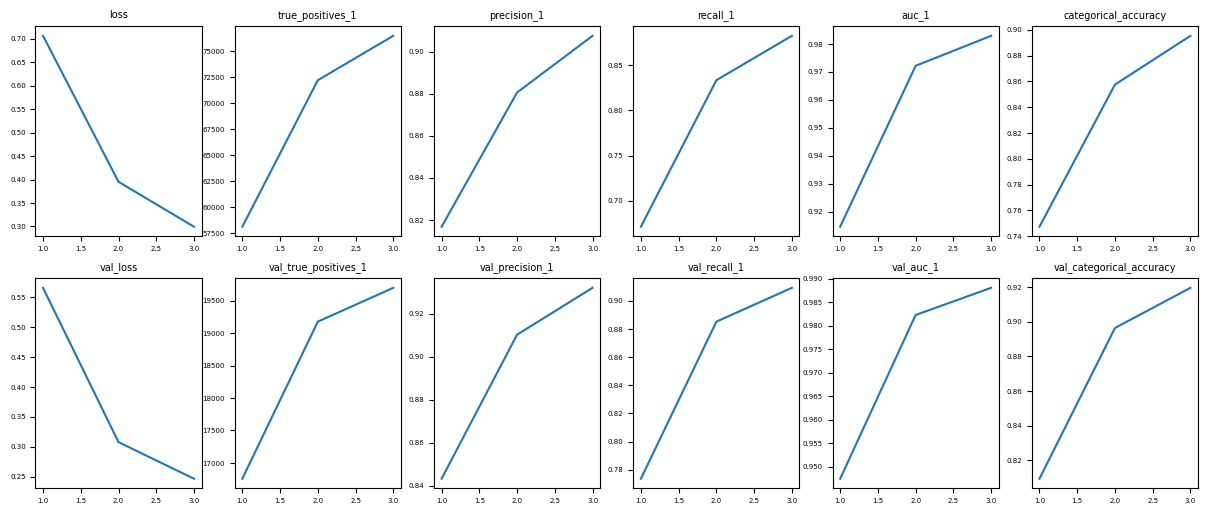

In [35]:
show_stats(resnet_stats,3)

In [7]:
with strategy.scope():
    st = time.process_time()
    resnet_stats = resnet_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3)
    et = time.process_time()
    print('Execution time:', et - st, 'seconds')

/tmp/ipykernel_15/1708519259.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_stats = resnet_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3)


Epoch 1/3


2023-09-01 22:50:11.624275: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_52/ReadVariableOp.
2023-09-01 22:50:11.843161: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_52/ReadVariableOp.


2708/2708 [==============================] - ETA: 0s - loss: 0.2581 - true_positives_1: 78218.0000 - precision_1: 0.9205 - recall_1: 0.9027 - auc_1: 0.9869 - categorical_accuracy: 0.9120

2023-09-02 00:15:58.075027: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
2023-09-02 00:15:58.246489: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


2708/2708 [==============================] - 6435s 2s/step - loss: 0.2581 - true_positives_1: 78218.0000 - precision_1: 0.9205 - recall_1: 0.9027 - auc_1: 0.9869 - categorical_accuracy: 0.9120 - val_loss: 0.2597 - val_true_positives_1: 19561.0000 - val_precision_1: 0.9190 - val_recall_1: 0.9031 - val_auc_1: 0.9872 - val_categorical_accuracy: 0.9109
Epoch 2/3
2708/2708 [==============================] - 5777s 2s/step - loss: 0.2293 - true_positives_1: 79251.0000 - precision_1: 0.9291 - recall_1: 0.9146 - auc_1: 0.9892 - categorical_accuracy: 0.9223 - val_loss: 0.2034 - val_true_positives_1: 20200.0000 - val_precision_1: 0.9410 - val_recall_1: 0.9326 - val_auc_1: 0.9909 - val_categorical_accuracy: 0.9367
Epoch 3/3
2708/2708 [==============================] - 5817s 2s/step - loss: 0.2120 - true_positives_1: 79826.0000 - precision_1: 0.9348 - recall_1: 0.9213 - auc_1: 0.9906 - categorical_accuracy: 0.9282 - val_loss: 0.1750 - val_true_positives_1: 20295.0000 - val_precision_1: 0.9484 - val

After three additional epochs, we were able to achieve even greater gains in all of the metrics.  Valudation accuracy is over .94 and valudation AUC is over .99.  It also appears that convergence has not yet been obtained.  That suggests that further training could improve the model even more.  However, due to constraints on time, we will stop here.  This round of training took 6 hours.  

|Metric|Training|Validation|
|:----|:--------:|:--------:|
|Loss | 0.2120 | 0.1750 |
|Precision | 0.9348 | 0.9484 | 
|Recall | 0.9213 | 0.9369 |
|AUC | 0.9906 | 0.9933 | 
|Accuracy | 0.9282 | 0.9420 | 

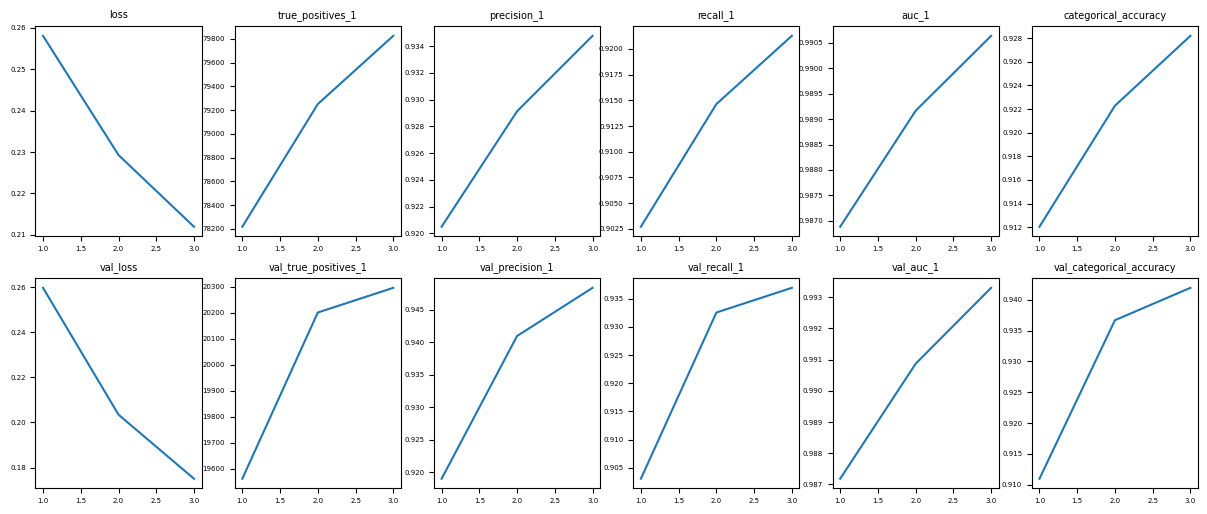

In [17]:
show_stats(resnet_stats,3)

This again will provide another good benchmark for the pre-trained model, which will come next.  


In [10]:
resnet_model.save('/kaggle/working/resnet_model.keras')

# ResNet50V2 Pre-Trained Model

Keras offers a number of standard neural network architectures, and parameter weights are available based on training from the ImageNet dataset.  A full list can be found here: https://keras.io/api/applications/  For the purposes of this project, I decided to employ ResNet50V2.  It has good performance on the ImageNet dataset (.95 Top-5 accuracy), but it has fewer parameters (25.6 million) than many of the other options and has better inference time (4.4ms).  It contains 50 segments: 48 convolution layers, one maxpool layer, and one average pool layer.  I will leverage a TPU for this last training task.  

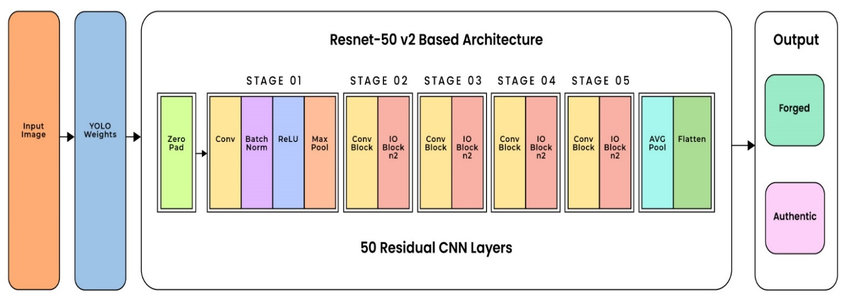

https://www.researchgate.net/figure/ResNet50v2-architecture_fig1_359153551

First I will instantiate the TPU so that we can speed up our training process:

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    #print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Then, to adapt this pre-trained model to the task at hand, I will follow Keras' guide to transfer learning: https://keras.io/guides/transfer_learning/

First, I will import the ResNet50V2 model with its weights from training on ImageNet.  We will create our own top layer, so include_top is set to "False".  Then we will set this base model so that it will not be trained.  We want to keep the existing weights and just train the new top layer will be created.  We do this to leverage the existing training as much as possible.

In [14]:
with strategy.scope():
    base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=(496, 496, 3), include_top=False) 
    base_model.trainable = False

Now we add the top layer, which includes a GlobalAveragePooling layer and the final dense layer.  

In [15]:
with strategy.scope():

    inputs = keras.Input(shape=(496, 496, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(4)(x)
    model = keras.Model(inputs, outputs)


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 496, 496, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23,572,996
Trainable params: 8,196
Non-trainable params: 23,564,800
_________________________________________________________________


Overall, the model now has 23.5 million parameters, only 8,196 which we will be initially training.  Later we will fine-tune the whole model.

Below I trained the model, for three epochs.  I wasn't sure how many would be necessary, so I trained it in a similar fashion as our baseline models.  It's likely that not all three will be necessary, though. 

In [46]:
with strategy.scope():
    st = time.process_time()
    
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.TruePositives(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(), tf.keras.metrics.CategoricalAccuracy()])

    model_stats = model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3)

    et = time.process_time()
    res = et - st
    print('Execution time:', et - st, 'seconds')

/tmp/ipykernel_15/2177782767.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_stats = model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=3)


Epoch 1/3


2023-08-30 13:31:09.364047: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-08-30 13:31:09.677715: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


2708/2708 [==============================] - ETA: 0s - loss: 0.3579 - true_positives_7: 73709.0000 - precision_7: 0.8566 - recall_7: 0.8507 - auc_7: 0.9324 - categorical_accuracy: 0.8782

2023-08-30 14:56:06.278831: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
2023-08-30 14:56:06.540671: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


2708/2708 [==============================] - 6394s 2s/step - loss: 0.3579 - true_positives_7: 73709.0000 - precision_7: 0.8566 - recall_7: 0.8507 - auc_7: 0.9324 - categorical_accuracy: 0.8782 - val_loss: 0.2590 - val_true_positives_7: 19184.0000 - val_precision_7: 0.8944 - val_recall_7: 0.8856 - val_auc_7: 0.9466 - val_categorical_accuracy: 0.9101
Epoch 2/3
2708/2708 [==============================] - 5798s 2s/step - loss: 0.2674 - true_positives_7: 76059.0000 - precision_7: 0.8750 - recall_7: 0.8778 - auc_7: 0.9431 - categorical_accuracy: 0.9087 - val_loss: 0.2289 - val_true_positives_7: 19330.0000 - val_precision_7: 0.9038 - val_recall_7: 0.8924 - val_auc_7: 0.9504 - val_categorical_accuracy: 0.9231
Epoch 3/3
2708/2708 [==============================] - 5826s 2s/step - loss: 0.2456 - true_positives_7: 76473.0000 - precision_7: 0.8824 - recall_7: 0.8826 - auc_7: 0.9452 - categorical_accuracy: 0.9160 - val_loss: 0.2358 - val_true_positives_7: 19339.0000 - val_precision_7: 0.8978 - val

Overall, it took almost 6 hours to train the model over three epochs. There were not many gains after the second epoch, so it might not have been necessary to add the third.  We have a validation accuracy of .92.  This is lower than our baseline control models.  However, we have only trained the top layer; we will also need to fine-tune the whole model with some additional training.


|Metric|Training|Validation|
|:----|:--------:|:--------:|
|Loss | 0.2456 | 0.2358 |
|Precision | 0.8824 | 0.8978 | 
|Recall | 0.8826 | 0.8928 |
|AUC | 0.9452 | 0.9474 | 
|Accuracy | 0.9160 | 0.9212 | 

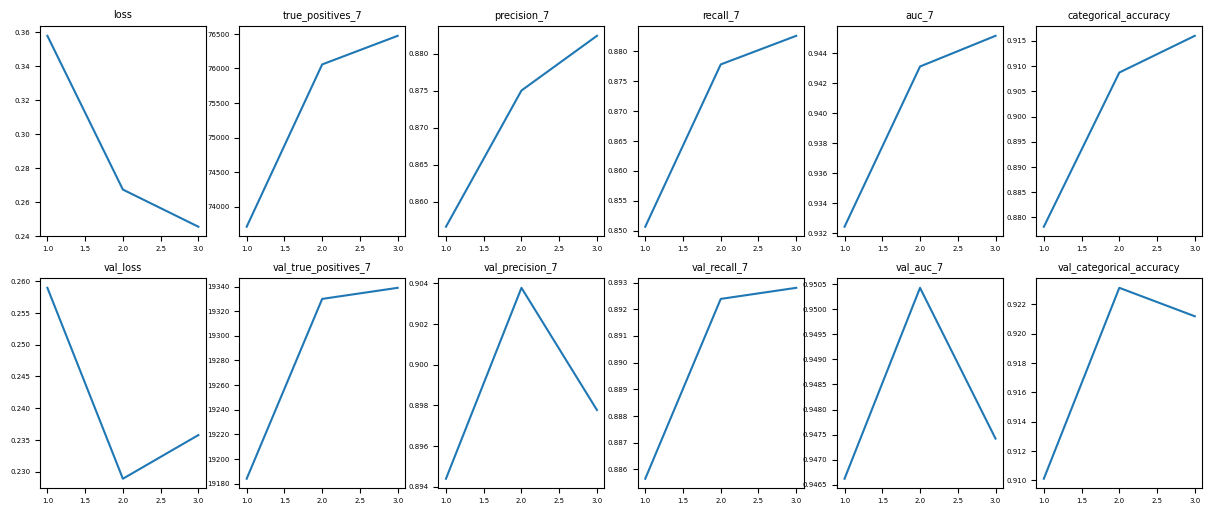

In [51]:
show_stats(model_stats, 3)

Next, I will fine-tune the whole model using a small learning rate.  Since I did this over multiple days, below I reload the model.  

Then, I use a learning rate of 0.00001, which is quite small.  We don't want to introduce big changes,  We want to leverage the existing weights as much as possible.  

In [62]:
with strategy.scope():
    st = time.process_time()
    model_tune.trainable = True
    model_tune.compile(optimizer=keras.optimizers.Adam(1e-5),
                      loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=[tf.keras.metrics.TruePositives(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(), tf.keras.metrics.CategoricalAccuracy()])

    model_stats = model_tune.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=1)
    et = time.process_time()
    res = et - st
    print('Execution time:', et - st, 'seconds')
    


/tmp/ipykernel_15/4143945274.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_stats = model_tune.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=1)
2023-08-30 18:56:45.625455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-08-30 18:56:46.258876: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


2708/2708 [==============================] - ETA: 0s - loss: 0.1359 - true_positives_13: 84666.0000 - precision_13: 0.8306 - recall_13: 0.9771 - auc_13: 0.9669 - categorical_accuracy: 0.9546

2023-08-30 20:15:46.646859: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
2023-08-30 20:15:46.916709: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


2708/2708 [==============================] - 5935s 2s/step - loss: 0.1359 - true_positives_13: 84666.0000 - precision_13: 0.8306 - recall_13: 0.9771 - auc_13: 0.9669 - categorical_accuracy: 0.9546 - val_loss: 0.1089 - val_true_positives_13: 21278.0000 - val_precision_13: 0.8858 - val_recall_13: 0.9823 - val_auc_13: 0.9782 - val_categorical_accuracy: 0.9631
Execution time: 7570.921902316 seconds


After a single epoch we have improved our validation accuracy to .963.  The validation recall is over .97 but precision is only .88.  The precision is a disappointment.  That means that of those labeled a particular class, only .87 were truly of that particular class. 

For curiosity's sake, I will continue to train the model for two more epochs to see whether incremental gains can be made.  

In [65]:
with strategy.scope():
    st = time.process_time()
    
    model_stats = model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=2)

    et = time.process_time()
    res = et - st
    print('Execution time:', et - st, 'seconds')

/tmp/ipykernel_15/1582750043.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_stats = model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=2, callbacks=[model_checkpoint6])


Epoch 1/2


2023-08-24 02:11:29.498507: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-08-24 02:11:30.094107: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


2708/2708 [==============================] - ETA: 0s - loss: 0.0942 - true_positives_13: 85632.0000 - precision_13: 0.8662 - recall_13: 0.9883 - auc_13: 0.9770 - categorical_accuracy: 0.9686

2023-08-24 03:29:13.063370: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
2023-08-24 03:29:13.328364: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


2708/2708 [==============================] - 5856s 2s/step - loss: 0.0942 - true_positives_13: 85632.0000 - precision_13: 0.8662 - recall_13: 0.9883 - auc_13: 0.9770 - categorical_accuracy: 0.9686 - val_loss: 0.1373 - val_true_positives_13: 21294.0000 - val_precision_13: 0.8637 - val_recall_13: 0.9831 - val_auc_13: 0.9752 - val_categorical_accuracy: 0.9558
Epoch 2/2
2708/2708 [==============================] - ETA: 0s - loss: 0.0748 - true_positives_13: 85921.0000 - precision_13: 0.8743 - recall_13: 0.9916 - auc_13: 0.9796 - categorical_accuracy: 0.9747WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


2708/2708 [==============================] - 5827s 2s/step - loss: 0.0748 - true_positives_13: 85921.0000 - precision_13: 0.8743 - recall_13: 0.9916 - auc_13: 0.9796 - categorical_accuracy: 0.9747 - val_loss: 0.1081 - val_true_positives_13: 21335.0000 - val_precision_13: 0.8878 - val_recall_13: 0.9849 - val_auc_13: 0.9779 - val_categorical_accuracy: 0.9648
Execution time: 14590.498975651999 seconds


After 2 additional epochs, there have been some marginal gains to the performance.  However, precision is still lagging compared to its previous levels.  The validation loss continued to decrease, while validation recall bumped up to .985 and AUC increased to .978.   There is a slight increase in precision, and it appears that further gains might be made.  But it is likely that many more epochs would be needed to regain some of what was lossed with the fine-tuning process.  These three additional epochs needed over 6 hours of training.

Below are the trainig stats for all 6 epochs.  

The first three epochs represent the training of the top layer, while the final three show the fine-tuning process.  The drop-off in the precision is quite apparent.  

|Metric|Training|Validation|
|:----|:--------:|:--------:|
|Loss | 0.0748 | 0.1081 |
|Precision | 0.8743 | 0.8878 | 
|Recall | 0.9916 | 0.9849 |
|AUC | 0.9796 | 0.9779 | 
|Accuracy | 0.9747 | 0.9648 |

In [18]:
stats_list = [('loss', [0.3579,0.2674,0.2456,0.1359,0.0942,0.0748]),
 ('precision_1', [0.8566,0.8750,0.8824,0.8306,0.8662,0.8743]),
 ('recall_1', [0.8507, 0.8778, 0.8826,0.9771,0.9883,0.9916]),
 ('auc_1', [0.9324,0.9431,0.9452,0.9669,0.9770,0.9796]),
 ('categorical_accuracy', [0.8782,0.9087,0.9160,0.9546,0.9686,0.9747]),
 ('val_loss', [0.2590,0.2289,0.2358,0.1089,0.1373,0.1081]),
 ('val_precision_1', [0.8944,0.9038,0.8978,0.8858,0.8637,0.8878]),
 ('val_recall_1', [0.8856,0.8924,0.8928,0.9823,0.9831,0.9849]),
 ('val_auc_1', [0.9466,0.9504,0.9474,0.9782,0.9752,0.9779]),
 ('val_categorical_accuracy', [0.9101,0.9231,0.9212,0.9631,0.9558,0.9648])]

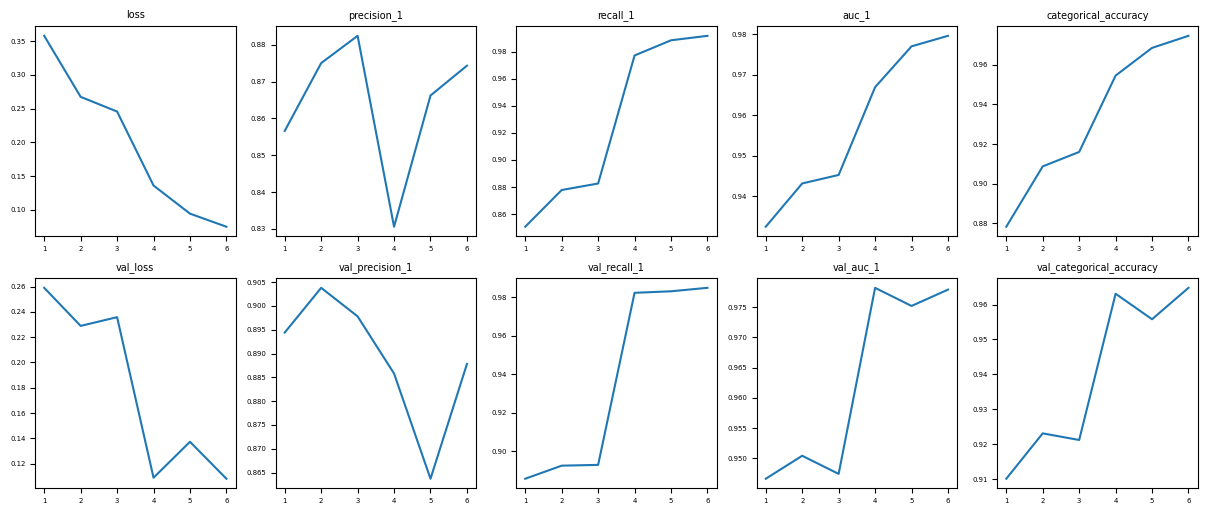

In [19]:
num_rows = 2
num_cols = 5
stat_index = 0

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15,6))

for i in range(num_rows):
    for j in range(num_cols):  
        axes[i, j].plot(range(1,7),stats_list[stat_index][1])
        axes[i,j].set_title(stats_list[stat_index][0], fontsize=7)
        axes[i,j].xaxis.set_tick_params(labelsize=5)
        axes[i,j].yaxis.set_tick_params(labelsize=5)
        stat_index += 1

# Analysis and Discussion

While the pre-trained ResNet50v2 model has over 23.5 million parameters, it achieved only marginally better gains in categorical accuracy than our baseline models from our validation metrics, and it performed worse in Precision and AUC than some of the other models.  However, so far we have only evaluated our models based on the validation data.  We will next need to evaluated whether the results are being skewed because we have so many more images of CNV and Normal than Drusen and DME in our training data and validation data.

## Validation Results
|Metric|VGG-Style|ResNet-Style|ResNet50v2|
|:----|:--------:|:--------:|:--------:|
|Loss | 0.2237 | 0.1750 | 0.1081 |
|Accuracy | 0.9343 | 0.9420 | 0.9648 |
|Precision |  0.9417 | 0.9484 | 0.8878 | 
|Recall | 0.9262 | 0.9369 | 0.9849 |
|AUC | 0.9886 | 0.9933 | 0.9779 | 
|# Parameters | 327,060 | 153,076 | 23,572,996 |
|Training Time | 35,299s | 45,972s | 42,710s | 
|Accelerator | GPU | TPU | TPU |



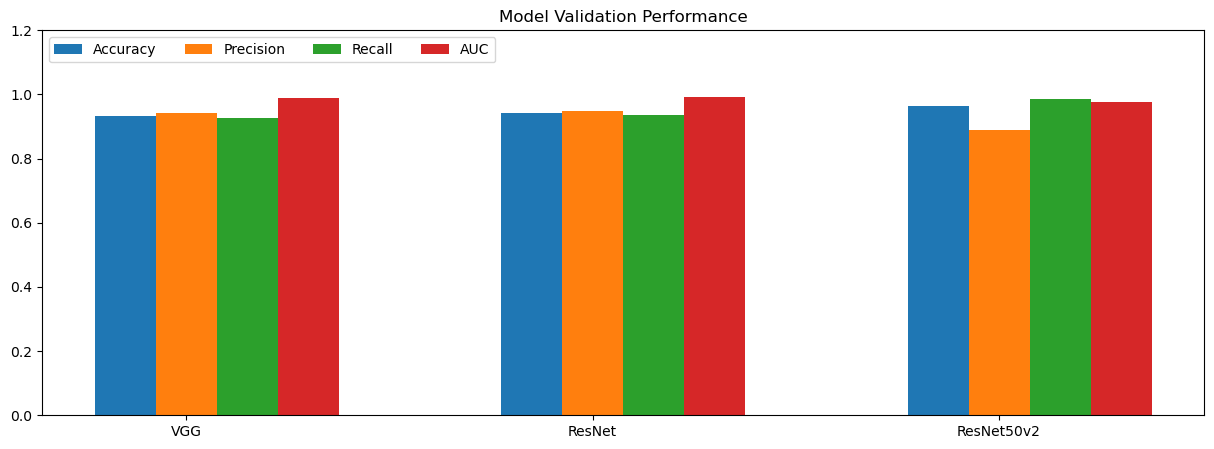

In [2]:
models = ("VGG", "ResNet", "ResNet50v2")
performance = {
    'Accuracy': (0.9343 , 0.9420 , 0.9648),
    'Precision': (0.9417 , 0.9484 , 0.8878),
    'Recall': (0.9262 , 0.9369 , 0.9849),
    'AUC': (0.9886 , 0.9933 , 0.97799),
}

x = np.arange(len(models))  
width = 0.15  
multiplier = 0

fig, ax = plt.subplots(figsize=(15, 5))

for attribute, measurement in performance.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)

    multiplier += 1

ax.set_title('Model Validation Performance')
ax.set_xticks(x + width, models)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.2)

plt.show()

## Test Results

Up to this point, we have not taken into consideration how well the models perform on particular classes.  Are our the results being skewed because we had so many more images of CNV and Normal than Drusen and DME?  To determine whether this is the case, I will now test the models on the balanced test data.  This test data, which was not included in the training or validation data, includes 250 images of each class.  This will give us a better understanding of how each model performs across each of the classes.  It is quite possible that the validation results are not a completely accurate view of performance.  If there a model learned to perform well on a class where there are many images available, then there are also a larger number of that class of images in the validation data.  Therefore, it is being tested more on the classes that it is good at.  

For each model, I will generate confusion matrixes, along with accuracy, precision, recall, and f-score metrics.

First, I will load 1,000 images evenly selected from the four classes and load these into a test dataset. 

In [67]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_directory(
    directory="/kaggle/input/oct-xrays/ZhangLabData/CellData/OCT/test/",
    target_size=(496, 496),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    seed=0,
    shuffle=False
)

Found 1000 images belonging to 4 classes.


Text(0.5, 1.0, 'Test Data')

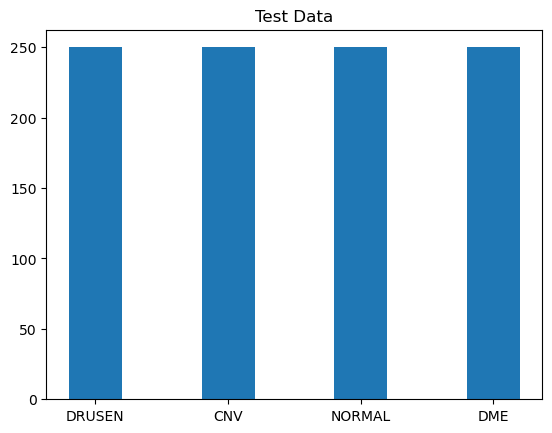

In [41]:
test_count, test_name = count_images_list("/kaggle/input/oct-xrays/ZhangLabData/CellData/OCT/test/")
plt.bar(test_name, test_count, width = 0.4)
plt.title("Test Data")

Then, I will generate predictions using each model and plot the confusion matrixes.  The following score fuction will be used for this purpose.  The assign_class function will be used to translate the softmax results to integer classes that can be compared with the test data targets.

In [13]:
def score(y_test, y_pred):
    print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
    print("Precision: " + str(precision_score(y_test, y_pred, average='weighted')))
    print("Recall: " + str(recall_score(y_test, y_pred, average='weighted')))
    print("F Score: " + str(f1_score(y_test, y_pred, average='weighted')))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

In [16]:
def assign_class(a):
    return np.argmax(a)

#### VGG-Style Model - 3 Epochs

In [12]:
test_generator.reset()
vgg_predictions = vgg_model.predict_generator(test_generator,verbose=1)

/tmp/ipykernel_28/2879509626.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vgg_predictions = vgg_model.predict_generator(test_generator,verbose=1)


32/32 [==============================] - 16s 510ms/step


In [16]:
vgg_predictions_cat = np.apply_along_axis(assign_class, 1, vgg_predictions)
targets = ([0] * 250) + ([1] * 250) + ([2] * 250) + ([3] * 250)

Accuracy: 0.858
Precision: 0.8781099752426085
Recall: 0.858
F Score: 0.848512438814392


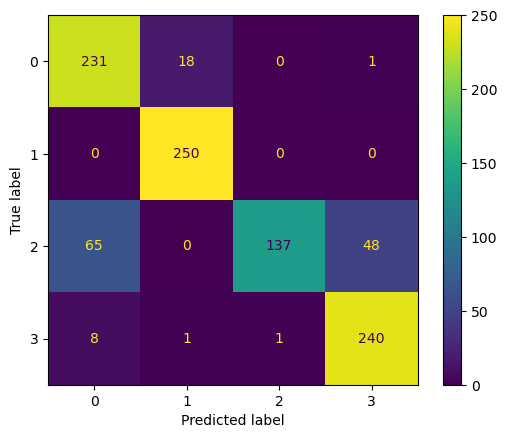

In [19]:
score(targets,vgg_predictions_cat)

In [7]:
print(test_generator.class_indices)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


#### VGG-Style Model - 6 Epochs

In [14]:
test_generator.reset()
vgg_predictions = vgg_model.predict_generator(test_generator,verbose=1)

/tmp/ipykernel_28/2879509626.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vgg_predictions = vgg_model.predict_generator(test_generator,verbose=1)


32/32 [==============================] - 18s 563ms/step


In [17]:
vgg_predictions_cat = np.apply_along_axis(assign_class, 1, vgg_predictions)
targets = ([0] * 250) + ([1] * 250) + ([2] * 250) + ([3] * 250)

Accuracy: 0.92
Precision: 0.9305538683605244
Recall: 0.92
F Score: 0.9191544645630787


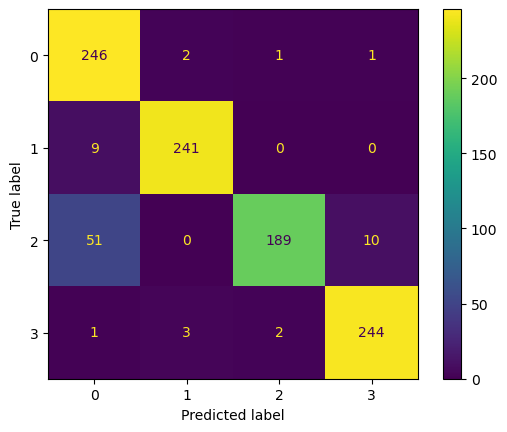

In [18]:
score(targets,vgg_predictions_cat)

In [7]:
print(test_generator.class_indices)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


The VGG-style model shows metrics that are similar to the validation data.  However, it is clear that it has struggled with correctly classifying Drusen.  Drusen had much less data than Normal and CNV, so perhaps this should be expected.  Otherwise, there is solid accuracy in identifying the other classes.  

#### ResNet-Style Model - 3 Epochs

In [30]:
test_generator.reset()
resnet_predictions = resnet_model.predict_generator(test_generator,verbose=1)

/tmp/ipykernel_15/522738418.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  resnet_predictions = resnet_model.predict_generator(test_generator,verbose=1)
2023-08-31 05:19:16.880956: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-31 05:19:17.028647: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


32/32 [==============================] - 30s 595ms/step


In [31]:
resnet_predictions_cat = np.apply_along_axis(assign_class, 1, resnet_predictions)
targets = ([0] * 250) + ([1] * 250) + ([2] * 250) + ([3] * 250)

Accuracy: 0.822
Precision: 0.8687721298380654
Recall: 0.822
F Score: 0.8171438211585447


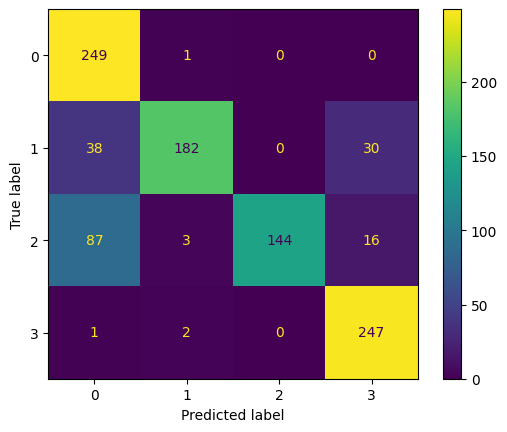

In [33]:
score(targets,resnet_predictions_cat)

In [7]:
print(test_generator.class_indices)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


#### ResNet-Style Model - 6 Epochs

In [11]:
test_generator.reset()
resnet_predictions = resnet_model.predict_generator(test_generator,verbose=1)

/tmp/ipykernel_15/522738418.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  resnet_predictions = resnet_model.predict_generator(test_generator,verbose=1)
2023-09-02 03:50:42.839573: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-02 03:50:42.989650: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


32/32 [==============================] - 33s 715ms/step


In [13]:
resnet_predictions_cat = np.apply_along_axis(assign_class, 1, resnet_predictions)
targets = ([0] * 250) + ([1] * 250) + ([2] * 250) + ([3] * 250)

Accuracy: 0.851
Precision: 0.8958994708994709
Recall: 0.851
F Score: 0.8486882902362285


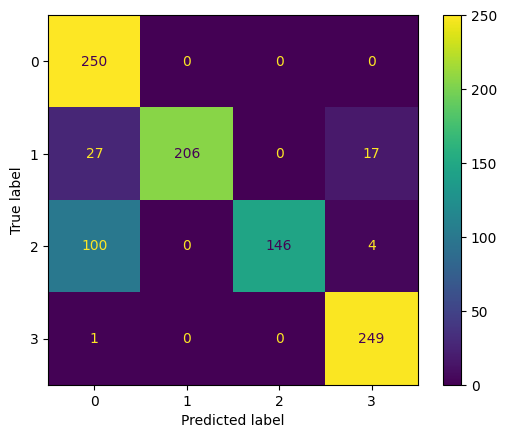

In [15]:
score(targets,resnet_predictions_cat)

In [7]:
print(test_generator.class_indices)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


Interestingly, our ResNet-style model perfomed much worse on the test data than on the validation data.  In fact, the metrics are close to .10 below the validation results.  This suggests that the imbalanced validation set was skewing performance.  As we can see, the model is very good at correctly predicting CNV and Normal.  In fact those classes are nearly perfect in their results.  However, results were much weaker for the remaining classes.  Since our validation data also included more Normal and CNV images, this ResNet-style model was allowed to cheat, in a sense.  It was being validated more on the classes that is was best at predicting.  

#### ResNet50v2 Model - 3 Epochs

In [47]:
test_generator.reset()
tranfer_predictions = model.predict_generator(test_generator,verbose=1)

/tmp/ipykernel_15/2528667602.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  tranfer_predictions = model.predict_generator(test_generator,verbose=1)
2023-08-30 18:41:52.683675: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-30 18:41:52.934492: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


32/32 [==============================] - 36s 715ms/step


In [48]:
tranfer_predictions_cat = np.apply_along_axis(assign_class, 1, tranfer_predictions)
targets = ([0] * 250) + ([1] * 250) + ([2] * 250) + ([3] * 250)

Accuracy: 0.859
Precision: 0.8825054650543875
Recall: 0.859
F Score: 0.8443897460509368


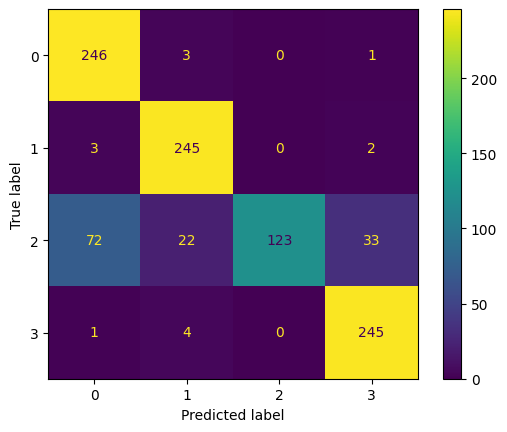

In [49]:
score(targets,tranfer_predictions_cat)

In [7]:
print(test_generator.class_indices)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


#### ResNet50v2 Fine-Tuned

In [66]:
test_generator.reset()
tranfer_predictions = model_tune.predict_generator(test_generator,verbose=1)

/tmp/ipykernel_15/2300487395.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  tranfer_predictions = model_tune.predict_generator(test_generator,verbose=1)


32/32 [==============================] - 12s 350ms/step


In [67]:
tranfer_predictions_cat = np.apply_along_axis(assign_class, 1, tranfer_predictions)
targets = ([0] * 250) + ([1] * 250) + ([2] * 250) + ([3] * 250)

Accuracy: 0.963
Precision: 0.9677700348432057
Recall: 0.963
F Score: 0.963025276441861


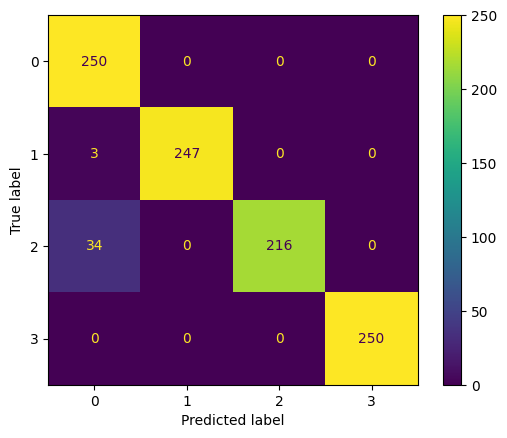

In [68]:
score(targets,tranfer_predictions_cat)

In [7]:
print(test_generator.class_indices)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


While the ResNet50v2 did not perform particularly well with just the training of the top layer (first three epochs) the fine-tuning process did bring about some real gains in performance.  In fact, we can now see that it really is the best performing model overall.  On the balanced test data, it out-performs every other model by several percentage points.  It performed perfectly on Normal and CNV, and nearly perfectly on DME.  It still struggled with Drusen, but had much better results for that class than the other models.  

|Metric|VGG-Style|ResNet-Style|ResNet50v2|
|:----|:--------:|:--------:|:--------:|
|Accuracy | 0.92 | 0.851 | 0.963 |
|Precision |  0.931 | 0.896 | 0.968 | 
|Recall | 0.92 | 0.851 | 0.963 |
|F Score | 0.919 | 0.849 | 0.963 | 

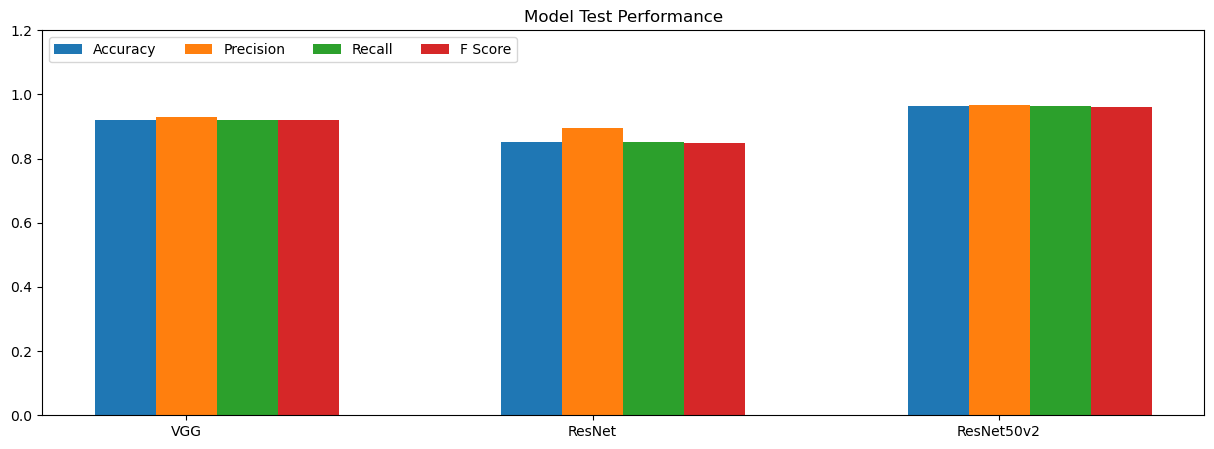

In [3]:
models = ("VGG", "ResNet", "ResNet50v2")
performance = {
    'Accuracy': (0.92 , 0.851 , 0.963),
    'Precision': (0.931 , 0.896 , 0.968),
    'Recall': (0.92 , 0.851 , 0.963),
    'F Score': (0.919 , 0.849 , 0.96),
}

x = np.arange(len(models))  
width = 0.15  
multiplier = 0

fig, ax = plt.subplots(figsize=(15, 5))

for attribute, measurement in performance.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)

    multiplier += 1

ax.set_title('Model Test Performance')
ax.set_xticks(x + width, models)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.2)

plt.show()

While the validation results might have suggested that the pre-trained model did not perform any better than the home-made models that were trained from scratch, evaluation on balanced test data does show us that real gains have been accomplished using the pre-trained model with some additional tuning.  The pre-trained model obtained a categorical accuracy of over .96, and it is clear that not all of the epochs of training were truly necessary.  Therefore, it is likely that better results could have been accomplished in half of the number of epochs of training than our baseline models.  One might question whether the use of a TPU made training for the pre-trained model faster than the models trained on the GPU.  However, after experimenting with the models, anecdotal evidence suggests that this was not the case.  In fact the ResNet-style model actually trained slower on the TPU than the GPU.  Both, performed much more quickly than no accelerator, but I did not see evidence to indicate that the models trained on the TPU trained more quickly.  Better computation time comparisons could have been obtained by training all the models on the same accelerator, but this was not possible due to resource constraints.     

A point of learning in this project is that validation data alone is not enough to gauge the performance of a model.  My validation data mirrored the makeup of my training data.  For those classes where there were many images, a greater number were also in the validation data.  If the model learned to perform well on those because there were more, it was also tested on those classes in a greater proportion during validation.  Therefore, the validation skewed the results to what the model was good at.  It got more and more right, but only the ones that were in particular classes.  However, in light of a balanced test set, it becomes clear that this was a kind of cheating.  A possible solution to this would be to use a balanced image set for the validation.  Then, with each epoch we could see clearly how it was performing across the classes, instead of just overall (which generally favored the most common classes).  I feel that this was a weakness in this project.  The validation results look better than they really were for some models.

Another place for learning in this project was strategy for saving models.  Initially, I attempted to checkpoint models, and this worked partially.  But, I began to notice that checkpoints were not saving.  I believe that this is because I incorrectly configured the checkpoints.  The checkpoints were looking to save the models with the highest validation accuracy.  Yet, the metric being used in my models was actually validation categorical accuracy.  The wrong metric was therefore being specified in the checkpoint.  It had nothing to look at to find the best performing model.  Also, I began to explicitly save models after traning was completed.  Yet, sometimes the notebook would timeout because I returned to the computer.  Also, Kaggle is somewhat buggy:  On multiple occasions I queued a code block to run after the training had finished.  Yet, for whatever reason it displayed a random error, and no model was saved.  Additionally, for two of my saved models, the models were corrupted.  I am not sure how this happened; they seemed to be saved successfully, but they could not be reloaded.  Due to these failures, it was necessary to do training multiple times.  In fact, I re-trained nearly every epoch more than once because of faulty saving.  I have learned to be slow when queuing code blocks in Kaggle, because this reduces the likelihood of those random errors.  

Due to the long training times necessary for this project, an additional object of learning was to double check model set up before starting training.  More than once I made silly mistakes that wasted hours of training time.  Rushing to get a training session going is likely going to hurt more in the long term due to mistakes that require starting training over again.  

A final question is how to improve performance of our classifier even more.  I believe that the most sensible way to do this is to train the model with more images of Drusen.  That likely would be enough.  If more images were not available, then I would suggest oversampling the existing Drusen images.  These images could be modified slightly through flips, shear, zoom, etc to create greater diversity that the model could learn on.  I believe that a better categorical accuracy is possible on this task.

# Conclusion

This project endeavored to create a classifer to accurately diagnose pathologies from a OCT scan.  Using two models trained from scratch as well as fine-tuned pre-trained model, RenNet50v2, it is clear that the pre-trained model did perform better using the fewer resources.  This suggests that models trained on other image recognition tasks can be adapted to other classification projects.  Overall, the project helped me to better understand the importance of using a balanced validation dataset to gauge perfomance, and it reinforced the need to implement good strategies to save models during the training process.  The project also was as source of encouragement, as I believe that accuracy of over .96 on this task is possible.  Further gains can likely be made through optimization and longer training.  It may be possible in the future to use machine learning in the doctor's office to classify OCT scans.

# References

> https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

> https://data.mendeley.com/datasets/rscbjbr9sj/3

> https://machinelearningmastery.com/transfer-learning-for-deep-learning/

> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

> https://keras.io/guides/transfer_learning/

> https://keras.io/api/applications/resnet/#resnet50v2-function